In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mapping to\from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [36]:
# build the dataset
block_size = 3
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
       # print(''.join(itos[i] for i in context),'---->', itos[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X) # X是例子
Y = torch.tensor(Y) # Y是标签 

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
C = torch.randn((27,2))

In [12]:
emb = C[X]
emb.shape # 32:有32个例子， 3：我们目前的神经网络有3个神经元， 2：每个神经元有两个权重

torch.Size([32, 3, 2])

In [13]:
W1 = torch.randn(6 ,100)
b1 = torch.randn(100)

In [15]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [16]:
h

tensor([[-0.5162, -0.7824, -0.2465,  ..., -0.8398,  0.8837,  0.8785],
        [-0.9911, -0.8967,  0.3335,  ..., -0.9968,  0.9665, -0.2902],
        [-0.9683,  0.9690,  0.3493,  ..., -0.9786, -0.9553,  0.7325],
        ...,
        [ 0.6652, -0.7751,  0.8833,  ...,  0.9991, -0.9999,  0.9947],
        [-1.0000,  0.4799,  0.9998,  ..., -1.0000,  0.9888,  0.9453],
        [-0.5805, -0.9954,  0.3426,  ..., -0.9997,  1.0000,  0.8064]])

In [17]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [18]:
logits = h @ W2 + b2

In [19]:
count = logits.exp()

In [20]:
prob = count / count.sum(1, keepdim=True)
prob

tensor([[3.8225e-06, 2.8055e-07, 4.6961e-08, 3.3364e-06, 1.1678e-07, 1.0027e-09,
         4.4767e-11, 7.3696e-13, 1.0707e-07, 7.6969e-06, 2.5573e-07, 9.0390e-09,
         1.5201e-13, 8.9277e-12, 8.8186e-01, 2.7598e-11, 8.5072e-07, 6.9656e-09,
         6.3237e-11, 2.4946e-04, 8.5720e-06, 1.1786e-01, 4.1533e-09, 9.2414e-10,
         4.1034e-10, 2.8059e-11, 9.5475e-06],
        [1.8934e-05, 4.4640e-06, 2.4128e-09, 1.8194e-06, 4.7250e-07, 4.5110e-08,
         1.6974e-15, 2.2088e-13, 7.1328e-10, 8.6773e-10, 3.7077e-07, 4.8438e-08,
         2.0957e-09, 1.1161e-14, 3.8001e-08, 3.8573e-09, 2.2798e-09, 1.3525e-10,
         4.2261e-10, 3.2657e-07, 6.1886e-01, 3.8111e-01, 1.8883e-08, 4.9985e-09,
         4.0059e-09, 2.2928e-12, 3.3903e-06],
        [8.0944e-10, 6.1246e-10, 1.4350e-11, 5.6950e-12, 1.3854e-10, 1.4461e-06,
         7.3729e-01, 5.1683e-08, 7.5516e-04, 8.7845e-12, 8.4163e-08, 9.1363e-06,
         1.0130e-09, 3.7485e-11, 2.4715e-11, 1.6725e-10, 7.7158e-05, 6.0012e-09,
         1.3099e-

In [21]:
loss = -prob[torch.arange(32),Y].log().mean() # 将prob重新排列成32行，27列，然后取出每一行的Y对应的列，然后求平均值

In [22]:
loss

tensor(13.8561)

In [23]:
# ---------------------------------

In [37]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [45]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [46]:
sum(p.nelement() for p in parameters) # 计算参数的数量

3481

In [47]:
for p in parameters:
    p.requires_grad = True

In [48]:
lre = torch.linspace(-3, 0 ,1000)
lrs = 10**lre

In [49]:
lri = []
lossi = []

for i in range(1000):
    
    # minibatch construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
    logits = h @ W2 + b2 # 32, 27
    # count = logits.exp()
    # prob = count / count.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None # 清空梯度
    loss.backward()
    
    # update weights
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track loss and lr
    lri.append(lr)
    lossi.append(loss.item())
    
# print(loss.item())
# 这里我们可以看到loss很小，说明我们的模型已经收敛了，但之所以很好是因为我们只训练了32个例子
# 我们有3481个参数，而只有32个例子，所以我们的模型很容易过拟合
# 而我们之所以达不到0，是因为我们前面的例子，例子中 ...的下一个既可以是e，也可以是h，也可以是其他，所以这里我们loss达不到0

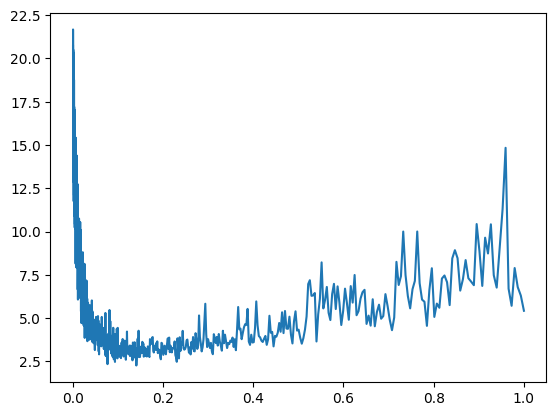

In [50]:
plt.plot(lri, lossi)